<a href="https://colab.research.google.com/github/yeonmi02/dlproject/blob/main/dlproject__Patient's_treatment_prediction__final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 딥러닝 프로젝트 최종 보고서: [환자의 치료 예측하기]

| **작성자**   | 20242401 김연미           |
| **발표 여부** | 미발표 |

## 1. 프로젝트 소개
- **프로젝트 동기**: 평소에도 의료 데이터에 대한 관심이 많았고 kaggle에서 데이터를 둘러보던 중 프로젝트에 하기에도 적합하고 데이터의 질도 좋은 세트를 발견하여서 진행하게 되었습니다.

- **프로젝트 목적**: 환자 데이터를 가지고 질병 별 치료 가능성과 결과를 예측하기위한 목적으로 프로젝트를 구상하고 실현하였습니다.

- **목표**: 질병 별로 환자의 치료 결과를 예측하기 위해서 다층 퍼셉트론을 비롯한 TabNet 모델과 Entity Embedding + MLP 모델을 사용하여 예측을 다양한 방식으로 도출해보는 것이 목표입니다.

- **기대 효과**: 이 예측 모델을 기반으로 환자들이나 의료진들이 질병별로 얼마나 치료가 가능할지 가늠할 수 있는 계기가 될 수 있습니다.

## 2. 주제 관련 배경
- **주제를 선택한 이유**: 앞서 말했듯이 의료 관련 데이터에 관심이 많았고 사람들이 실생활에 도움이 될 수 있는 예측이 뭘까 생각하던 중 가장 적합하다는 생각이 들어 선택하게 되었습니다.

- **필요성**: 현재 의료 기술이 빠르게 발달하고 있고 또한 현대인 질병들도 함께 증가하는 추세를 보이는데 그에 따라 치료 가능성에 대한 환자들의 궁금증도 늘고있습니다. 이 프로젝트가 성공적으로 구현된다면 많은 환자들의 궁금증을 풀어줄 수 있는 계기가 되고 질병으로 인한 불안함 해소에도 도움이 될 것 같습니다.

## 3. 데이터 셋 소개
-  **데이터 출처**: kaggle 데이터를 사용했습니다. [참고한 데이터의 kaggle 주소](https://www.kaggle.com/datasets/blueblushed/hospital-dataset-for-practice)

- **전체 행과 열의 수**: 총 984개의 열이 있고 10개의 칼럼['Patient_ID', 'Age', 'Gender', 'Condition', 'Procedure', 'Cost', 'Length_of_Stay', 'Readmission', 'Outcome', 'Satisfaction']이 있습니다.

- **데이터 변수 설명**

| 변수명              | 데이터 타입 | 설명                                           |
| ---------------- | ------ | -------------------------------------------- |
| `Age`            | 숫자형    | 환자의 나이                                       |
| `Gender`         | 범주형    | 환자의 성별
| `Condition`      | 범주형    | 진단된 주요 질환
| `Procedure`      | 범주형    | 실시된 의료 시술 종류
| `Cost`           | 숫자형    | 시술/입원에 발생한 총 비용
| `Length_of_Stay` | 숫자형    | 병원에 머문 기간
| `Outcome`        | 범주형    | 치료 결과
| `Satisfaction`   | 숫자형    | 환자의 만족도 점수 |





#데이터 불러오기

In [633]:
# 관련 라이브러리 임포트
import torch
import numpy as np
import random

# 모델 학습 결과를 고정시키기 위한 시드 고정하는 코드
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [634]:
# 관련 라이브러리 임포트하는 코드
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오는 코드
patient = pd.read_csv('/content/drive/MyDrive/hospital data analysis.csv')
patient.head(10)

,Patient_ID,Age,Gender,Condition,Procedure,Cost,Length_of_Stay,Readmission,Outcome,Satisfaction
0,1,45,Female,Heart Disease,Angioplasty,15000,5,No,Recovered,4
1,2,60,Male,Diabetes,Insulin Therapy,2000,3,Yes,Stable,3
2,3,32,Female,Fractured Arm,X-Ray and Splint,500,1,No,Recovered,5
3,4,75,Male,Stroke,CT Scan and Medication,10000,7,Yes,Stable,2
4,5,50,Female,Cancer,Surgery and Chemotherapy,25000,10,No,Recovered,4
5,6,68,Male,Hypertension,Medication and Counseling,1000,2,No,Stable,4
6,7,55,Female,Appendicitis,Appendectomy,8000,4,No,Recovered,3
7,8,40,Male,Fractured Leg,Cast and Physical Therapy,3000,6,No,Recovered,4
8,9,70,Female,Heart Attack,Cardiac Catheterization,18000,8,Yes,Stable,2
9,10,25,Male,Allergic Reaction,Epinephrine Injection,100,1,No,Recovered,5


## 4. 데이터 전처리
- 의료 데이터 셋의 변수별 특성과 역할에 따라 전처리를 수행했습니다.

 🔹 Patient_ID - 환자의 고유한 값으로 예측에  필요없는 특성이라고 판단해서 삭제했습니다.

 🔹 Age - 환자의 나이 정보로 정수형 데이터 형태입니다. 이상치 확인 결과 발견되지 않아서 정규화하는 전처리를 수행했습니다.

 🔹 Gender - 환자의 성별 정보로 라벨 인코딩을 활용해 정수형으로 변환했습니다

 🔹 Condition - 환자의 질병 유형에 관한 정보로 범주형 데이터입니다. 범주 개수가 적어 Label Encoding 적용 후에 Entity Embedding 입력으로 사용했습니다.

 🔹 Procedure - 환자의 시술 종류로 범주형 데이터이고 Condition과 같은 처리를 진행했습니다.

 🔹 Cost - 시술에 대한 비용으로 수치형 데이터이고 고비용의 이상치가 존재하여 로그변환 후에 정규화 전처리를 진행했습니다.

 🔹 Length_of_Stay - 입원 기간을 나타내는 정보로 한쪽으로 너무 치우쳐져 정규화를 진행했습니다.

 🔹 Satisfaction - 환자 만족도를 나타내는 데이터로 결측치가 존재해서 평균값으로 대체했고 정규화 처리했습니다.

 🔹 Readmission - 재입원 여부 데이터로 이진 분류를 진행했습니다.

 🔹 Outcome - 시술의 최종 결과로 에측 변수입니다.

# 데이터 전처리 하기

In [635]:
# 전처리를 하기 위한 라이브러리 임포트하는 코드
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [636]:
# 데이터 안에 존재하는 특성 출력하는 코드
print(patient.columns.tolist())

['Patient_ID', 'Age', 'Gender', 'Condition', 'Procedure', 'Cost', 'Length_of_Stay', 'Readmission', 'Outcome', 'Satisfaction']


In [637]:
# 예측하는 과정에서 필요없는 특성을 제거하는 코드
if 'Patient_ID' in patient.columns:
    patient.drop(columns=['Patient_ID'], inplace=True)

In [638]:
# 데이터에서 결측값들을 적절하게 채우는 코드
patient.fillna({
    'Age': patient['Age'].median(),
    'Gender': patient['Gender'].mode()[0],
    'Condition': 'Unknown',
    'Procedure': 'Unknown',
    'Cost': patient['Cost'].median(),
    'Length_of_Stay': patient['Length_of_Stay'].median(),
    'Readmission': 'No',
    'Outcome': 'Unknown',
    'Satisfaction': patient['Satisfaction'].mode()[0]
}, inplace=True)

In [639]:
# 범주형 특성들을 수치형으로 변환하는 코드
le = LabelEncoder()
patient['Outcome_Label'] = le.fit_transform(patient['Outcome'])

In [640]:
# 환자의 데이터를 원핫인코딩하는 코드
categorical_cols = ['Gender', 'Condition', 'Procedure', 'Readmission']
patient = pd.get_dummies(patient, columns=categorical_cols)

In [641]:
# 입력변수와 타겟변수를 처리하는 코드
X = patient.drop(columns=['Outcome'])
y = patient['Outcome_Label']

In [642]:
# 입력 데이터를 바탕으로 표준화를 진행하는 코드
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [643]:
# 데이터를 분할하는 코드
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [644]:
# 데이터 전처리를 완료하고 확인하는 코드
print("데이터 전처리 완료함")
print("X_train shape:", X_train.shape)
print("y label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

데이터 전처리 완료함
X_train shape: (787, 39)
y label mapping: {'Recovered': np.int64(0), 'Stable': np.int64(1)}


In [645]:
# 입력 데이터의 크기와 타겟 데이터의 크기를 확인하는 코드
X_scaled.shape
y.shape

(984,)

In [646]:
from sklearn.preprocessing import LabelEncoder

# 범주형 타켓 변수를 숫자 레이블로 변환하는 코드
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [647]:
# 각 변수의 타입을 확인하는 코드
print(type(y_train))
print(y_train[:10])
print([type(x) for x in y_train[:10]])

<class 'pandas.core.series.Series'>
507    1
345    1
933    1
71     0
544    0
645    1
532    1
905    1
658    0
562    1
Name: Outcome_Label, dtype: int64
[<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]


In [648]:
# 라벨 값의 종류를 확인하는 코드
print("라벨 종류:", patient['Outcome'].unique())

# 라벨의 분포 형태 알아보는 코드
print("라벨 분포:")
print(patient['Outcome'].value_counts())

# 결측치를 확인하는 코드
missing_labels = patient['Outcome'].isnull().sum()
print(f"라벨 결측치 개수: {missing_labels}")

라벨 종류: ['Recovered' 'Stable']
라벨 분포:
Outcome
Recovered    591
Stable       393
Name: count, dtype: int64
라벨 결측치 개수: 0


In [649]:
import pandas as pd

# 훈련 데이터와 테스트 데이터의 라벨 분포를 출력하는 코드
print("Train 라벨 분포:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nTest 라벨 분포:")
print(pd.Series(y_test).value_counts(normalize=True))

Train 라벨 분포:
Outcome_Label
0    0.601017
1    0.398983
Name: proportion, dtype: float64

Test 라벨 분포:
Outcome_Label
0    0.598985
1    0.401015
Name: proportion, dtype: float64


In [650]:
import numpy as np

# 넘파이 배열로 변환하는 코드
if 'pandas' in str(type(X_train)):
    X_train = X_train.to_numpy(dtype=np.float32)
    X_test = X_test.to_numpy(dtype=np.float32)

if 'pandas' in str(type(y_train)):

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # 넘파이 배열로 변환하는 코드
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

## 5. 다층 퍼셉트론 모델 구조

- **데이터 분할**: 가장 기본적으로 사용하는 데이터 분할 비율을 사용했습니다.

- **입력**: 수치형 변수는 그대로 사용하고, 범주형 변수는 nn.Embedding을 통해 임베딩 벡터로 변환하여 입력층에 결합했습니다.

- **은닉층**: 총 2개의 은닉층 구성 -> 첫 번째 은닉층: 64차원 / 두 번째 은닉층: 32차원입니다.

- **출력층**: 1개의 뉴런을 사용하여 이진 분류를 수행했습니다.

- **활성화 함수**: ReLU를 각 은닉층에 사용하였고 출력층에는 시그모이드 함수를 사용했습니다.

- **옵티마이저**: 모델에 사용한 옵티마이저는 제일 많이 사용한다는 adam입니다.

- **손실함수**: 모델에 사용한 손실함수는 크로스엔트로피입니다.

- **에포크**: 에포크는 25로 설정하여 학습했습니다.

# 다층 퍼셉트론 모델 구현하기

In [651]:
# 관련 라이브러리 임포트하는 코드
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [652]:
# 모델 구현하고 컴파일하는 코드
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [653]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

In [654]:
# 딥러닝 모델을 훈련시키는 코드
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    verbose=2
)

Epoch 1/25
25/25 - 2s - 95ms/step - accuracy: 0.7865 - loss: 0.5374 - val_accuracy: 1.0000 - val_loss: 0.3213
Epoch 2/25
25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.1932 - val_accuracy: 1.0000 - val_loss: 0.0991
Epoch 3/25
25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0576 - val_accuracy: 1.0000 - val_loss: 0.0308
Epoch 4/25
25/25 - 0s - 20ms/step - accuracy: 1.0000 - loss: 0.0209 - val_accuracy: 1.0000 - val_loss: 0.0139
Epoch 5/25
25/25 - 1s - 20ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 6/25
25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 7/25
25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 8/25
25/25 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 9/25
25/25 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 10/25
2

##5-1. 다층 퍼셉트론 모델 성능 결과

- MLP 모델을 학습하고 난 다음 학습이 제대로 이루어졌는지 확인하기 위한 예측 성능 지표를 평가하고 출력하는 코드를 실행했습니다.

- **결과**: 기대와는 다르게 데이터 셋이 적어서 그런지 몰라도 너무 지나치게 잘 예측하는 과적합이 의심되는 지표가 출력되었습니다.

- 훈련 데이터 셋의 평가와 테스트 데이터 셋의 평가가 모두 100%로 예측을 성공하는 지표는 결코 모델이 좋다고 할 수 없기 때문에 다른 방법을 사용해보기로 했습니다.

In [655]:
# 훈련한 데이터로 예측하고 평가하는 코드
y_train_pred = (model.predict(X_train) >= 0.5).astype(int).reshape(-1)
y_test_pred = (model.predict(X_test) >= 0.5).astype(int).reshape(-1)

print("Train 데이터 성능:")
print(classification_report(y_train, y_train_pred))
print("Train 데이터 혼동 행렬:")
print(confusion_matrix(y_train, y_train_pred))

print("\nTest 데이터 성능:")
print(classification_report(y_test, y_test_pred))
print("Test 데이터 혼동 행렬:")
print(confusion_matrix(y_test, y_test_pred))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       473
         1.0       1.00      1.00      1.00       314

    accuracy                           1.00       787
   macro avg       1.00      1.00      1.00       787
weighted avg       1.00      1.00      1.00       787

Train 데이터 혼동 행렬:
[[473   0]
 [  0 314]]

Test 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       118
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Test 데이터 혼동 행렬:
[[118   0]
 [  0  79]]


In [656]:
from sklearn.metrics import classification_report, confusion_matrix

# 훈련 데이터셋을 예측하는 코드
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()

# 테스트 데이터셋을 예측하는 코드
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [657]:
# 훈련 데이터셋을 평가하는 코드
print("Train 데이터 성능:")
print(classification_report(y_train, y_train_pred))
print("Train 데이터 혼동 행렬:")
print(confusion_matrix(y_train, y_train_pred))

# 테스트 데이터셋을 평가하는 코드
print("\nTest 데이터 성능:")
print(classification_report(y_test, y_test_pred))
print("Test 데이터 혼동 행렬:")
print(confusion_matrix(y_test, y_test_pred))

Train 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       473
         1.0       1.00      1.00      1.00       314

    accuracy                           1.00       787
   macro avg       1.00      1.00      1.00       787
weighted avg       1.00      1.00      1.00       787

Train 데이터 혼동 행렬:
[[473   0]
 [  0 314]]

Test 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       118
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Test 데이터 혼동 행렬:
[[118   0]
 [  0  79]]


##  5-2. 다층 퍼셉트론 과적합 의심 문제 해결 첫 번째

- 과적합 된 가능성이 있어서 데이터 양을 늘리는 방향으로 해결해볼 수 있다고 생각해서 데이터를 늘려봤습니다.

- 데이터 양을 늘리는 코드에 대해서는 지식이 부족했기 때문에 Chat GPT의 도움을 받아 SMOTE라는 방법을 추천해주었고 코드를 실행해봤습니다.

- SMOTE는 데이터 불균형을 완화시켜주는 코드로 한쪽으로 편향되는 문제점을 막고 과적합 문제에서도 유용하다고 알려져 있습니다.

- 그 결과 SMOTE를 처리하기 전에는 314개였던 데이터가 처리하고 난 다음에는 473으로 조금 상승하였습니다.

- 본격적으로 모델을 다시 학습하기 전에 주성분 분석으로 처리를 한 다음 데이터의 양상을 볼 수 있는 시각화도 진행해봤습니다.

- 아까 위에서 했던 MLP 모델을 똑같이 구현했고 에포크 수만 30으로 늘려서 학습과 평가를 진행했습니다.







In [658]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 데이터 불균형을 조정하기위해 SMOTE 사용하는 코드
print("Before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({np.float32(0.0): 473, np.float32(1.0): 314})
After SMOTE: Counter({np.float32(1.0): 473, np.float32(0.0): 473})


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

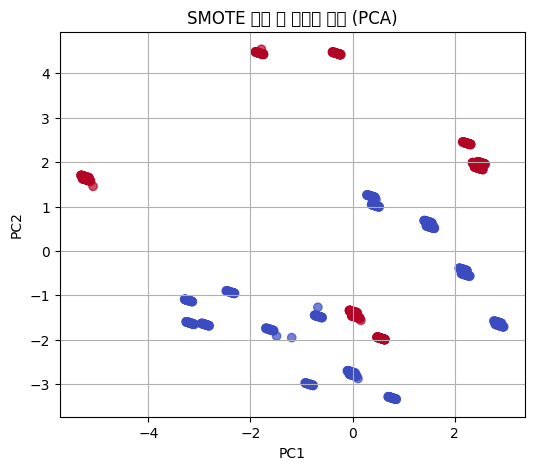

In [659]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 주성분 분석하는 코드
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)

# 시각화하는 코드
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_resampled, cmap='coolwarm', alpha=0.7)
plt.title('SMOTE 적용 후 데이터 분포 (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

In [660]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 훈련 데이터에 SMOTE를 적용해서 균형을 맞추는 코드
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({np.float32(0.0): 473, np.float32(1.0): 314})
After SMOTE: Counter({np.float32(1.0): 473, np.float32(0.0): 473})


In [661]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [662]:
# 모델 다시 생성하고 컴파일하는 코드
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [663]:
# 모델 재훈련하는 코드
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5686 - loss: 0.6979 - val_accuracy: 1.0000 - val_loss: 0.2926
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.2067 - val_accuracy: 1.0000 - val_loss: 0.0949
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0688 - val_accuracy: 1.0000 - val_loss: 0.0308
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0244 - val_accuracy: 1.0000 - val_loss: 0.0123
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss

## 5-3. SMOTE 처리 후 모델 평가의 성능

- 데이터의 양이 늘어서 과적합의 문제가 조금을 해결될거라 믿었는데 여전히 같은 성능을 보이고 있어서 소용이 없었던 것 같습니다.

- 데이터 양이 너무 적어서 과도하게 학습된 것이 근본적으로 해결이 안된 모습을 보이고 있습니다.

- 다른 대안으로 우선 교차검증을 실행해보기로 결정했습니다.

In [664]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측하는 코드
y_pred_train = model.predict(X_train_resampled).round()
y_pred_test = model.predict(X_test).round()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [665]:
# 평가 지표들을 출력하는 코드
print("Train 데이터 성능:")
print(classification_report(y_train_resampled, y_pred_train))
print("Train 데이터 혼동 행렬:")
print(confusion_matrix(y_train_resampled, y_pred_train))

print("\nTest 데이터 성능:")
print(classification_report(y_test, y_pred_test))
print("Test 데이터 혼동 행렬:")
print(confusion_matrix(y_test, y_pred_test))

Train 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       473
         1.0       1.00      1.00      1.00       473

    accuracy                           1.00       946
   macro avg       1.00      1.00      1.00       946
weighted avg       1.00      1.00      1.00       946

Train 데이터 혼동 행렬:
[[473   0]
 [  0 473]]

Test 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       118
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Test 데이터 혼동 행렬:
[[118   0]
 [  0  79]]


## 5-4. 문제 해결을 위해 교차검증 실시해보기

- 가장 먼저 교차검증을 위한 라이브러리들을 임포트 하였습니다.

- **입력층**: 입력 차원은 input_dim으로 전처리된 입력 데이터의 특성 수에 대응되도록 구섷했고 원-핫 인코딩 등을 포함한 모든 특성을 실수형으로 모델에 전달하도록 구현했습니다.

- **은닉층**: 은닉층은 1개로 구성했으며 기본값인 64로 형성했습니다. 또한 ReLu함수를 사용하여 구현했습니다.

- **출력층**: 출력층은 분류 대상 클래스로 정의되었고 CrossEntropyLoss를 사용하는 구조입니다.

- 전체 모델 흐름 요약

Input (input_dim 차원)

↓

Linear (input_dim → hidden_dim)

↓

ReLU

↓

Linear (hidden_dim → output_dim)

↓

CrossEntropyLoss

- 다음으로 장치 설정을 하고 5개의 폴드로 나누는 구조를 만들었습니다.

- **교차 검증 학습**: 훈련 데이터와 테스트 데이터를 나누고 범주형 특성의 원핫인코딩을 비롯해서 칼럼을 정리한 다음 텐서 변환과 DataLoader 구성, MLP 모델 초기화와 학습을 하고 성능 평가를 진행하는 과정을 반복하는 구조로 구현했습니다.
학습은 10 에포크동안 수행되고 배치 사이즈는 32입니다.


## 교차검증 해보기

In [666]:
# 교차검증을 위한 라이브러리 임포트하는 코드
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# MLP 모델 코드
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [667]:
# 장치를 설정하고 검증 코드 준비하는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [668]:
# 교차검증을 위한 라이브러리 임포트하는 코드
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

#y 전체에 라벨 인코더를 적용하는 코드
le = LabelEncoder()
y_encoded = pd.Series(le.fit_transform(y))

fold_accuracies = []

# 5층 교차검증을 순차적으로 완료하는 코드
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded.iloc[train_idx], y_encoded.iloc[val_idx]

    X_train = pd.get_dummies(X_train).astype(float)
    X_val = pd.get_dummies(X_val).astype(float)
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32),
                                  torch.tensor(y_train.values, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32),
                                torch.tensor(y_val.values, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = MLP(input_dim=X_train.shape[1], output_dim=len(set(y))).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습하는 코드
    model.train()
    for epoch in range(10):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (batch_idx + 1) % 10 == 0:
                print(f"Fold {fold}, Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {running_loss / 10:.4f}")
                running_loss = 0.0

# 평가하는 코드
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true.extend(labels.numpy())

    acc = accuracy_score(true, preds)
    fold_accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

print(f"\nAverage Accuracy over {len(fold_accuracies)} folds: {np.mean(fold_accuracies):.4f}")


Fold 0, Epoch 1, Batch 10, Loss: 84.6225
Fold 0, Epoch 1, Batch 20, Loss: 24.2292
Fold 0, Epoch 2, Batch 10, Loss: 9.2285
Fold 0, Epoch 2, Batch 20, Loss: 6.9993
Fold 0, Epoch 3, Batch 10, Loss: 4.8864
Fold 0, Epoch 3, Batch 20, Loss: 5.9034
Fold 0, Epoch 4, Batch 10, Loss: 3.6337
Fold 0, Epoch 4, Batch 20, Loss: 3.6152
Fold 0, Epoch 5, Batch 10, Loss: 3.9712
Fold 0, Epoch 5, Batch 20, Loss: 4.1138
Fold 0, Epoch 6, Batch 10, Loss: 3.5334
Fold 0, Epoch 6, Batch 20, Loss: 4.1835
Fold 0, Epoch 7, Batch 10, Loss: 2.0804
Fold 0, Epoch 7, Batch 20, Loss: 2.5302
Fold 0, Epoch 8, Batch 10, Loss: 1.7693
Fold 0, Epoch 8, Batch 20, Loss: 3.2944
Fold 0, Epoch 9, Batch 10, Loss: 1.4426
Fold 0, Epoch 9, Batch 20, Loss: 2.5315
Fold 0, Epoch 10, Batch 10, Loss: 1.4487
Fold 0, Epoch 10, Batch 20, Loss: 1.4749
Fold 0 Accuracy: 0.7868
Fold 1, Epoch 1, Batch 10, Loss: 37.3094
Fold 1, Epoch 1, Batch 20, Loss: 10.9970
Fold 1, Epoch 2, Batch 10, Loss: 3.2100
Fold 1, Epoch 2, Batch 20, Loss: 0.9059
Fold 1, Ep

In [669]:
splits = list(skf.split(X, y_encoded))
print(f"Number of folds: {len(splits)}")

Number of folds: 5


# 5-4. MLP 모델 구현 결과 분석

- **첫 번째 MLP**: 우선 데이터 셋의 양이 적어서 그런건지 아닌지 모르겠지만 과적합이 의심되는 결과가 나타난 결과를 얻었습니다.

- **두 번째 MLP**: SMOTE를 사용하여 데이터를 늘리는 방향으로 다시 모델을 구현하고 학습하였지만 데이터가 늘어난 양이 충분하지 않아서 성능은 그대로 과적합 상태를 유지한 결과를 얻었습니다.

- **세 번째 MLP**: 마지막으로 5-FOLD 교차 검증을 실행해본 결과 각 폴드의 에포크 마다 손실이 감소하는 경향을 보이고 정확도도 차이는 있지만 대부분 65% 이상으로 꽤 괜찮은 정확도를 나타내고 있습니다. 평균 정확도도 성능이 많이 올라서 과적합이 어느 정도 해결된 모습을 보인다고 분석할 수 있지만 확실하게 단정지을 수 없습니다.

- 다층 퍼셉트론은 초반에 과적합이 심하게 발생하였고 교차 검증으로 어느 정도 과적합을 해결하면서 성능을 안정적으로 만들어 결과를 도출하였습니다.

## 6. TabNet 모델 구조

- **TabNet이란?** : TabNet은 Google Cloud의 연구팀에서 2019년에 발표한 테이블 데이터에 특화된 딥러닝 모델입니다. Attention 기반의 Feature selection을 톧해서 각 단계별로 알맞은 특성을 선택해 학습하는 알고리즘입니다. 다른 모델과 비교했을때 딥러닝 분야에서 뛰어난 성능을 보이고 추론 속도가 빠른 장점을 가지고 있습니다. 각 단계에서 어떤 특성이 사용되었는지 알 수 있기 때문에 모델을 이해하기 쉽다는 특징도 있습니다.

- Tabet 모델을 구현하기 위한 전단계로 기본적으로 타겟 변수를 인코딩하고 데이터 타입을 수치형 배열로 출력하는 코드를 작성했습니다. 그리고 장치 설정도 해주었습니다.

- **모델 구조**: TabNet 모델의 분류기를 초기화 해주고 각 디코더와 어텐션 크기를 64, 학습 단계수는 5, 연결 가중치는 1.5, 규제 계수는 1e-4로 설정했습니다. 옵티마이저는 Adam이고 스케줄러를 사용해 학습률을 조정했습니다.

- **모델 학습**: 학습 데이터로 모델을 학습하고 검증 데이터도 함께 전달해서 학습 중 정확도를 출력합니다. 조기 종료를 사용해서 10 에포크 동안 개선이 전혀 없다면 학습을 중단하도록 구현했습니다.

# TabNet 모델 구현하기

In [670]:
# TabNet 라이브러리 설치
!pip install pytorch-tabnet

In [671]:
# 관련 라이브러리 임포트하는 코드
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report
import torch
from sklearn.preprocessing import LabelEncoder

In [672]:
# 문자형 타겟 변수를 수치형으로 변환하는 코드
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [673]:
# 데이터를 넘파이 배열로 변환하는 코드
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

In [674]:
# 장치 설정하는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [675]:
# TabNet 모델을 구현하는 코드
clf = TabNetClassifier(
    device_name=device.type,
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [676]:
# 모델 학습하는 코드
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 1.01845 | test_accuracy: 0.75127 |  0:00:00s
epoch 1  | loss: 0.44464 | test_accuracy: 0.79188 |  0:00:00s
epoch 2  | loss: 0.51668 | test_accuracy: 0.79188 |  0:00:01s
epoch 3  | loss: 0.38292 | test_accuracy: 0.87817 |  0:00:01s
epoch 4  | loss: 0.14286 | test_accuracy: 0.82741 |  0:00:02s
epoch 5  | loss: 0.04497 | test_accuracy: 0.90355 |  0:00:03s
epoch 6  | loss: 0.021   | test_accuracy: 0.86802 |  0:00:03s
epoch 7  | loss: 0.007   | test_accuracy: 0.86802 |  0:00:04s
epoch 8  | loss: 0.0896  | test_accuracy: 0.86802 |  0:00:06s
epoch 9  | loss: 0.08589 | test_accuracy: 0.86802 |  0:00:07s
epoch 10 | loss: 0.02242 | test_accuracy: 0.80203 |  0:00:09s
epoch 11 | loss: 0.01954 | test_accuracy: 0.73096 |  0:00:10s
epoch 12 | loss: 0.00655 | test_accuracy: 0.73096 |  0:00:12s
epoch 13 | loss: 0.05316 | test_accuracy: 0.6599  |  0:00:12s
epoch 14 | loss: 0.01982 | test_accuracy: 0.6599  |  0:00:13s
epoch 15 | loss: 0.05136 | test_accuracy: 0.6599  |  0:00:13s

Early s

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 6-1. 첫 번째 TabNet 모델 성능 평가

- MLP 모델과 비교했을 때 템넷 모델은 성능이 안정적인 모습을 보입니다. 하지만 코드를 실행할 때마다 조금씩 결과가 다르지만 여전히 과적합이 의심됩니다.

- **예측 결과 시각화**: 예측 결과를 시각화해서 만든 그래프에도 보면 알 수 있듯이 1에 몰려있는 것을 확인할 수 있습니다. 성능 지표와 같은 결과이고 과적합이 의심됩니다.

- **특성 중요도 시각화**: TabNet의 장점인 특성 중요도를 시각화 해봤습니다. 그래프에서 보면 어떤 특성들이 학습에서 중요하게 작용했는지 알 수 있습니다.

In [677]:
# 평가하고 결과 출력하는 코드
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       118
           1       0.89      0.86      0.88        79

    accuracy                           0.90       197
   macro avg       0.90      0.90      0.90       197
weighted avg       0.90      0.90      0.90       197



In [678]:
# 예측된 확률을 알아보는 코드
proba = clf.predict_proba(X_test)

recovered_idx = 0
recovered_proba = proba[:, recovered_idx]

# 치료 가능성에 대한 예측을 출력하는 코드
recovered_proba = proba[:, recovered_idx]

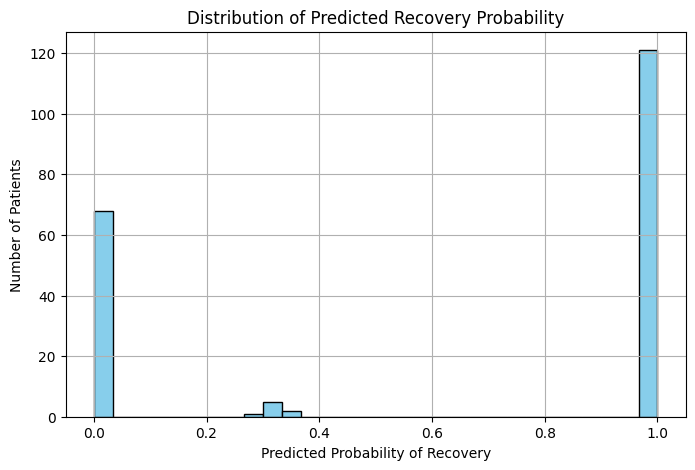

In [679]:
import matplotlib.pyplot as plt

# 시각화하는 코드
plt.figure(figsize=(8, 5))
plt.hist(recovered_proba, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Recovery Probability")
plt.xlabel("Predicted Probability of Recovery")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()

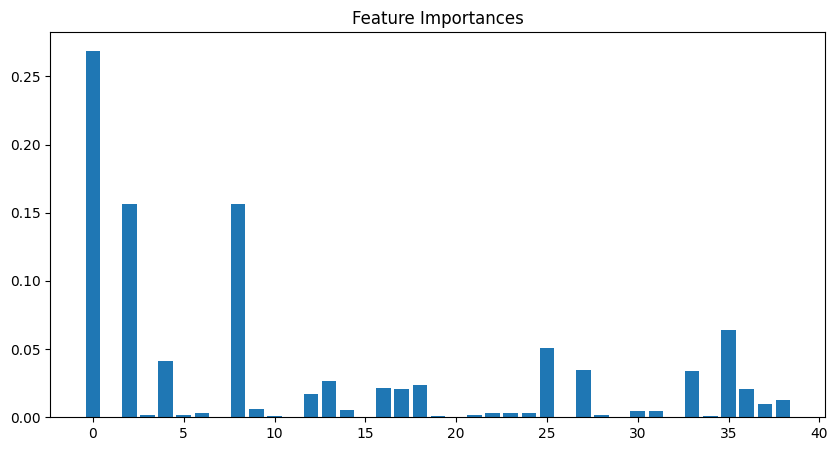

In [680]:
# 중요한 특성을 시각화하는 코드
plt.figure(figsize=(10, 5))
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.show()

## 6-2. TabNet 모델 개선해서 다시 학습해보기

- MLP와 마찬가지로 SMOTE를 사용해 데이터 불균형을 완화하는 방식으로 진행하고 하이퍼파라미터 조정 방식으로 문제 해결을 시도했습니다.

- **모델 구조**: 디코더와 어텐션의 수를 8로 설정해 모델의 용량을 줄였고, 단계 수를 3으로 설정해 특성 선택과 변환율을 3단계로 수행합니다. 학습률은 0.02로 Adam 옵티마이저로 동일하게 설정했습니다. 10 단계마다 학습률을 0.9로 줄이는 옵티마이저 설정도 했습니다.

- **모델 오류**: 데이터의 변수 설정이 모델과 맞지 않아 오류가 나서 데이터 타입을 확인하고 알맞게 조정하는 코드를 거쳐 다시 모델을 실행했습니다.



In [681]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 데이터를 분할하는 코드
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 데이터 불균형을 처리하는 코드
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [682]:
from pytorch_tabnet.tab_model import TabNetClassifier

# TabNet 모델 구현하는 코드
clf = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,
    gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',    #
    verbose=1,
    seed=42
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


## * 모델 학습 오류로 변환 다시 실행

In [683]:
# 데이터 타입과 결측값을 확인하는 코드
print(X_train_res.dtypes)
print(X_train_res.isnull().sum())

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Outcome_Label                                     int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                         

In [684]:
from sklearn.preprocessing import LabelEncoder

# 문자형 범수를 처리하는 코드
for col in X_train_res.columns:
    if X_train_res[col].dtype == 'object':
        le = LabelEncoder()
        X_train_res[col] = le.fit_transform(X_train_res[col].astype(str))

# 결측값을 처리하는 코드
X_train_res = X_train_res.fillna(0)

In [685]:
# 테스트 데이터 셋에도 같은 처리하는 코드
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        le = LabelEncoder()
        X_test[col] = le.fit_transform(X_test[col].astype(str))
X_test = X_test.fillna(0)

In [686]:
# 다시 데이터 타입과 결측값 확인하는 코드
print(X_train_res.dtypes)
print(X_train_res.isnull().sum())
print(X_train_res.head())

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Outcome_Label                                     int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                         

In [687]:
from sklearn.preprocessing import LabelEncoder

encoders = {}

# 데이터 별로 인코딩하는 코드
for col in X_train_res.columns:
    if X_train_res[col].dtype == 'object':
        le = LabelEncoder()
        X_train_res[col] = le.fit_transform(X_train_res[col].astype(str))
        if col in X_test.columns:
            X_test[col] = le.transform(X_test[col].astype(str))
        encoders[col] = le

In [688]:
# NAN값을 0으로 채우는 전처리 코드
X_train_res = X_train_res.fillna(0)
X_test = X_test.fillna(0)

In [689]:
# 데이터 타입 확인하는 코드
print(X_train_res.dtypes)
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Outcome_Label                                     int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                         

In [690]:
# bool 타입 데이터를 int 형태로 변환하는 코드
bool_cols = X_train_res.select_dtypes(include=['bool']).columns
X_train_res[bool_cols] = X_train_res[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

In [691]:
 # bool이 int로 바뀌었는지 확인하는 코드
print(X_train_res.dtypes)
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Outcome_Label                                     int64
Gender_Female                                     int64
Gender_Male                                       int64
Condition_Allergic Reaction                       int64
Condition_Appendicitis                            int64
Condition_Cancer                                  int64
Condition_Childbirth                              int64
Condition_Diabetes                                int64
Condition_Fractured Arm                           int64
Condition_Fractured Leg                           int64
Condition_Heart Attack                            int64
Condition_Heart Disease                           int64
Condition_Hypertension                            int64
Condition_Kidney Stones                         

In [692]:
# 모델을 학습하는 코드
clf.fit(
    X_train_res.values, y_train_res.values,
    eval_set=[(X_train_res.values, y_train_res.values), (X_test.values, y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.65842 | train_accuracy: 0.58245 | valid_accuracy: 0.5533  |  0:00:00s
epoch 1  | loss: 0.44481 | train_accuracy: 0.58879 | valid_accuracy: 0.53807 |  0:00:00s
epoch 2  | loss: 0.22426 | train_accuracy: 0.63214 | valid_accuracy: 0.59391 |  0:00:00s
epoch 3  | loss: 0.0725  | train_accuracy: 0.98626 | valid_accuracy: 0.99492 |  0:00:01s
epoch 4  | loss: 0.02069 | train_accuracy: 1.0     | valid_accuracy: 1.0     |  0:00:01s
epoch 5  | loss: 0.00596 | train_accuracy: 1.0     | valid_accuracy: 1.0     |  0:00:01s
epoch 6  | loss: 0.0018  | train_accuracy: 1.0     | valid_accuracy: 1.0     |  0:00:02s
epoch 7  | loss: 0.00089 | train_accuracy: 1.0     | valid_accuracy: 1.0     |  0:00:02s
epoch 8  | loss: 0.00052 | train_accuracy: 1.0     | valid_accuracy: 1.0     |  0:00:03s
epoch 9  | loss: 0.00038 | train_accuracy: 1.0     | valid_accuracy: 1.0     |  0:00:03s
epoch 10 | loss: 0.00148 | train_accuracy: 1.0     | valid_accuracy: 1.0     |  0:00:04s
epoch 11 | loss: 0.00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 6-2. 모델 수정 후 성능 평가

- 기대와 달리 여러 파라미터를 조정하고 모델을 개선했음에도 과적합은 해결되지 않는 문제가 지속되고 있습니다.

- 그에 따라 훈련 데이터와 테스트 데이터만이 아닌 검증 데이터 셋도 평가하는 코드를 만들어 비교해보는 모델을 만들었습니다.

- **모델 구조**: 검증 데이터 셋을 가지고 모델을 학습하고 평가하기 위해서 데이터 타입에 따라 필요한 전처리들을 수행하고 모델을 학습했습니다.

In [693]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 예측하는 코드
y_pred = clf.predict(X_test.values)

# 평가 관련 지표 출력하는 코드
print("Classification Report:")
print(classification_report(y_test.values, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_pred))

print("Accuracy:", accuracy_score(y_test.values, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Confusion Matrix:
[[118   0]
 [  0  79]]
Accuracy: 1.0


In [694]:
from sklearn.model_selection import train_test_split

# 데이터 분할하는 코드
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# 훈련 데이터를 검증 데이터 셋으로 분할하는 코드
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, stratify=y_train_full, test_size=0.2, random_state=42)

In [695]:
# bool 타입 데이터를 int 형태로 변환하는 코드
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})
X_val = X_val.astype({col: 'int' for col in X_val.select_dtypes(include='bool').columns})

In [696]:
# 데이터 타입 별 개수를 출력하는 코드
print(X_train.dtypes.value_counts())

int64    39
Name: count, dtype: int64


In [697]:
# 각 데이터를 넘파이 배열로 변환하는 코드
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
y_train_np = y_train.values
y_val_np = y_val.values

In [698]:
# 정수형으로 변환하는 코드
X_val = X_val.astype({col: 'int' for col in X_val.select_dtypes(include='bool').columns})

In [699]:
# 넘파이 배열로 바꾸고 정수형으로 변환하는 코드
X_val_np = X_val.values.astype(np.float32)
y_val_pred = clf.predict(X_val_np)

In [700]:
# 학습하는 코드
clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20
)

epoch 0  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 1  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 2  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 3  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 4  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 5  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


epoch 6  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 7  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 8  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 9  | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 10 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 11 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 12 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 13 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 14 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 15 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 16 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 17 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 18 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 19 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s
epoch 20 | loss: 0.0     | val_accuracy: 0.60127 |  0:00:00s

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_accuracy = 0.60

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 6-2. 모델 수정 후 성능 평가

- 밑의 성능 지표를 보면 정확도는 낮은 편이지만 1 클래스에 대해서 0 클래스보다 예측을 못하고 있는 문제점이 발새했습니다.

- 클래스 1을 예측하게 하기 위해서 데이터 불균형을 완화하고 클래스 가중치를 부여하는 방향, threshold 값 조정, 데이터 전처리 수정 방향으로 모델을 개선해 학습을 해보았습니다.

- **데이터 전처리 수정**: bool 타입의 데이터를 int형으로 전처리 해주고 특정 수치형 칼럼들에 대해서 스케일링을 해주었습니다. 또한 데이터를 넘파이 배열로 변환해 모델을 다시 학습하였습니다.

In [701]:
# 예측하는 코드
y_val_pred = clf.predict(X_val_np)

# 평가 출력하는 코드
from sklearn.metrics import classification_report
print(classification_report(y_val_np, y_val_pred))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75        95
           1       0.00      0.00      0.00        63

    accuracy                           0.60       158
   macro avg       0.30      0.50      0.38       158
weighted avg       0.36      0.60      0.45       158



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [702]:
from sklearn.preprocessing import StandardScaler

# bool 타입을 int로 변환하는 코드
for df in [X_train, X_val]:
    df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)

# 스케일링하는 코드
scaler = StandardScaler()
num_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

# 넘파이로 변환하는 코드
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
y_train_np = y_train.values
y_val_np = y_val.values

In [703]:
from pytorch_tabnet.tab_model import TabNetClassifier

# 모델 구현하는 코드
clf = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-3,
    optimizer_params=dict(lr=0.02),
    mask_type='entmax'
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [704]:
# 모델 학습하는 코드
clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.83847 | val_accuracy: 0.60759 |  0:00:00s
epoch 1  | loss: 0.45783 | val_accuracy: 0.50633 |  0:00:00s
epoch 2  | loss: 0.32204 | val_accuracy: 0.61392 |  0:00:00s
epoch 3  | loss: 0.26743 | val_accuracy: 0.72785 |  0:00:01s
epoch 4  | loss: 0.15055 | val_accuracy: 0.81013 |  0:00:01s
epoch 5  | loss: 0.0976  | val_accuracy: 0.88608 |  0:00:02s
epoch 6  | loss: 0.04427 | val_accuracy: 0.93671 |  0:00:02s
epoch 7  | loss: 0.02632 | val_accuracy: 0.87342 |  0:00:02s
epoch 8  | loss: 0.01255 | val_accuracy: 0.86076 |  0:00:03s
epoch 9  | loss: 0.00614 | val_accuracy: 0.84177 |  0:00:03s
epoch 10 | loss: 0.00399 | val_accuracy: 0.8481  |  0:00:03s
epoch 11 | loss: 0.01504 | val_accuracy: 0.84177 |  0:00:03s
epoch 12 | loss: 0.00822 | val_accuracy: 0.83544 |  0:00:04s
epoch 13 | loss: 0.00381 | val_accuracy: 0.83544 |  0:00:04s
epoch 14 | loss: 0.01958 | val_accuracy: 0.84177 |  0:00:04s
epoch 15 | loss: 0.00297 | val_accuracy: 0.85443 |  0:00:04s
epoch 16 | loss: 0.00413

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 6-2. 데이터 전처리 수정 후 예측 성능 평가

- **검증 데이터 셋 성능**: 이 성능 지표를 보면 아까와 달리 1클래스에 대해서 완벽히 예측하는 모습을 보이고 있고 정밀도는 클래스 0은 100%, 클래스 1은 86%이고 재현율도 각각 94%,93%로 높습니다. 정확도도 지금까지 학습한 모델에서 제일 좋은 94%가 나왔습니다. 이 지표를 보면 과적합이 완전히 사라졌다는 것을 알 수 있고 모델의 성능도 좋다는 결과를 얻을 수 있습니다.

- 아직 모델의 데이터의 불균형이 남아있음에도 높은 성능을 보이고 있습니다.

- **테스트 데이터 셋 성능** : 검증 데이터는 높은 성능을 보이는 반면 테스트 데이터 셋은 검증 데이터 셋 성능보다 많이 떨어지는 모습을 보이고 있습니다. 검증 데이터와 달리 테스트 데이터는 여전히 클래스 1을 예측하지 못하는 결과를 보이고 그에 따라 전체적인 정확도도 떨어진 모습입니다.

- **Regularization 강화 모델**: 테스트 데이터의 성능도 같이 높이기 위해 Regularization 강화를 실시했습니다. 우선 TabNet 모델을 초기화해서 재설정하고 학습률을 0.02로 변경해주었습니다. 그리고 mask_type='sparsemax'라는 코드를 사용하여 최소한의 특성을 선택하는 방식으로 모델을 구현했습니다.

In [705]:
# 예측하는 코드
y_val_pred = clf.predict(X_val_np)
from sklearn.metrics import classification_report
print(classification_report(y_val_np, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        95
           1       0.86      1.00      0.93        63

    accuracy                           0.94       158
   macro avg       0.93      0.95      0.94       158
weighted avg       0.95      0.94      0.94       158



In [706]:
for col in X_train.columns:
    if col not in patient.columns:
        patient[col] = 0

patient = patient[X_train.columns]


bool_cols = patient.select_dtypes(include='bool').columns
patient[bool_cols] = patient[bool_cols].astype(int)


num_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']
patient[num_cols] = scaler.transform(patient[num_cols])


patient_np = patient.values.astype(np.float32)

y_pred = clf.predict(patient_np)

print("예측 결과:", y_pred)

<ipython-input-706-685120d58819>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient[bool_cols] = patient[bool_cols].astype(int)


예측 결과: [0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0
 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1
 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0
 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1
 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0
 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 1 0
 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0
 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0
 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0
 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1
 0 1 0 0 0 1 0 1 0

<ipython-input-706-685120d58819>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient[num_cols] = scaler.transform(patient[num_cols])


## ❤ 성능이 좋게 나온 모델을 바탕으로 새로운 데이터 예측해보기

In [707]:
import pandas as pd
import numpy as np

# 새로운 환자 데이터 입력하기
def predict_treatment_possibility(condition_input, X_train, scaler, clf):

    patient_dict = {
        'Age': 50,
        'Cost': 5000,
        'Length_of_Stay': 5,
        'Outcome': 0,
        'Satisfaction': 3,
        'Outcome_Label': 0,
        'Condition': condition_input,
        'Gender': 'Male',
        'Procedure': 'Medication and Counseling',
        'Readmission': 'No'
    }


    patient = pd.DataFrame([patient_dict])

    # 원핫인코딩
    categorical_cols = ['Gender', 'Condition', 'Procedure', 'Readmission']
    patient_encoded = pd.get_dummies(patient, columns=categorical_cols)


    for col in X_train.columns:
        if col not in patient_encoded.columns:
            patient_encoded[col] = 0
    patient_encoded = patient_encoded[X_train.columns]

    # 수치형 인코딩하기
    num_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']
    patient_encoded[num_cols] = scaler.transform(patient_encoded[num_cols])


    patient_np = patient_encoded.values.astype(np.float32)

    # 예측하기
    pred = clf.predict(patient_np)

    # 출력하기
    print(f"입력하신 질병 '{condition_input}' 에 대한 치료 가능성 예측 결과: {pred[0]}")

In [708]:
condition = input("예측할 질병명을 입력하세요: ")
predict_treatment_possibility(condition, X_train, scaler, clf)

예측할 질병명을 입력하세요: Cancer
입력하신 질병 'Cancer' 에 대한 치료 가능성 예측 결과: 1


# 테스트 데이터 셋 평가

In [709]:
# 테스트 데이터 셋 평가하는 코드
X_test_fixed = X_test.copy()
for col in X_test_fixed.columns:
    if X_test_fixed[col].dtype == 'bool':
        X_test_fixed[col] = X_test_fixed[col].astype(int)

y_test_pred = clf.predict(X_test_fixed.values)

In [710]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 테스트 데이터 셋 평가 지표 출력하는 코드
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.59      0.95      0.72       118
           1       0.00      0.00      0.00        79

    accuracy                           0.57       197
   macro avg       0.29      0.47      0.36       197
weighted avg       0.35      0.57      0.43       197

Confusion Matrix:
[[112   6]
 [ 79   0]]
Accuracy: 0.5685279187817259


# Regularization 강화

In [711]:
from pytorch_tabnet.tab_model import TabNetClassifier

# 모델 재설정하는 코드
clf = TabNetClassifier(
    lambda_sparse=1e-3,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    mask_type='sparsemax'
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [712]:
# 재설정한 모델 학습하는 코드
clf.fit(
    X_train.values, y_train.values,
    eval_set=[(X_val.values, y_val.values)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 1.03083 | val_accuracy: 0.72152 |  0:00:00s
epoch 1  | loss: 0.67134 | val_accuracy: 0.72785 |  0:00:00s
epoch 2  | loss: 0.50963 | val_accuracy: 0.77848 |  0:00:00s
epoch 3  | loss: 0.41165 | val_accuracy: 0.75316 |  0:00:00s
epoch 4  | loss: 0.30921 | val_accuracy: 0.76582 |  0:00:00s
epoch 5  | loss: 0.26804 | val_accuracy: 0.84177 |  0:00:00s
epoch 6  | loss: 0.17506 | val_accuracy: 0.91772 |  0:00:00s
epoch 7  | loss: 0.10413 | val_accuracy: 1.0     |  0:00:00s
epoch 8  | loss: 0.06897 | val_accuracy: 0.98101 |  0:00:00s
epoch 9  | loss: 0.02198 | val_accuracy: 0.96203 |  0:00:01s
epoch 10 | loss: 0.01327 | val_accuracy: 0.91772 |  0:00:01s
epoch 11 | loss: 0.01456 | val_accuracy: 0.93671 |  0:00:01s
epoch 12 | loss: 0.00711 | val_accuracy: 0.94304 |  0:00:01s
epoch 13 | loss: 0.00541 | val_accuracy: 0.96203 |  0:00:01s
epoch 14 | loss: 0.00834 | val_accuracy: 0.93671 |  0:00:01s
epoch 15 | loss: 0.00743 | val_accuracy: 0.83544 |  0:00:01s
epoch 16 | loss: 0.00597

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 6-3.Regularization 강화 모델 성능 평가

- **검증 데이터 성능**: 강화를 한 다음에 갑자기 검증 데이터 셋의 성능이 과적합된 모습의 결과가 나왔습니다.

- **테스트 데이터 성능**: 오히려 테스트 데이터 셋은 아까 성능보다 나아진 모습으로 클래스 1에 대해서 예측을 하기 시작했습니다.

In [713]:
# 예측한 결과를 출력하는 코드
y_val_pred = clf.predict(X_val.values)
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00        63

    accuracy                           1.00       158
   macro avg       1.00      1.00      1.00       158
weighted avg       1.00      1.00      1.00       158



In [714]:
# 테스트 데이터 셋 성능 출력하는 코드
y_test_pred = clf.predict(X_test.to_numpy(dtype=np.float32))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.46      0.40      0.43       118
           1       0.25      0.30      0.28        79

    accuracy                           0.36       197
   macro avg       0.36      0.35      0.35       197
weighted avg       0.38      0.36      0.37       197



In [715]:
# 데이터 타입 출력하는 코드
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Outcome_Label                                     int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                         

In [716]:
# 데이터에 문자열이 있는지 확인하는 코드
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        print(col, X_test[col].unique())


X_test = X_test.select_dtypes(exclude=['object'])

## 6-4. TabNet 모델 분류기 사용

- 비교적 깊은 모델 형태로 넣어봤습니다. 처음 TabNet 모델을 사용할 때와 같은 모델 구조이고 이전보다 더 나은 아키텍쳐와 옵티마이저를 사용했습니다.

In [717]:
# TabNet 분류기 정의히는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clf = TabNetClassifier(
    device_name=device.type,
    n_d=64, n_a=64,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [718]:
# 모델 학습하는 코드
clf.fit(
    X_train.values,
    y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 1.09414 | val_0_auc: 0.5457  |  0:00:00s
epoch 1  | loss: 0.29029 | val_0_auc: 0.54184 |  0:00:00s
epoch 2  | loss: 0.03192 | val_0_auc: 0.89396 |  0:00:00s
epoch 3  | loss: 0.02183 | val_0_auc: 0.44068 |  0:00:01s
epoch 4  | loss: 0.00515 | val_0_auc: 0.86081 |  0:00:01s
epoch 5  | loss: 0.00595 | val_0_auc: 0.86081 |  0:00:01s
epoch 6  | loss: 0.00044 | val_0_auc: 0.81013 |  0:00:01s
epoch 7  | loss: 0.0003  | val_0_auc: 0.81013 |  0:00:01s
epoch 8  | loss: 0.00447 | val_0_auc: 0.81013 |  0:00:02s
epoch 9  | loss: 0.00015 | val_0_auc: 0.75424 |  0:00:02s
epoch 10 | loss: 0.00018 | val_0_auc: 0.95795 |  0:00:02s
epoch 11 | loss: 0.00086 | val_0_auc: 1.0     |  0:00:02s
epoch 12 | loss: 6e-05   | val_0_auc: 0.94615 |  0:00:03s
epoch 13 | loss: 3e-05   | val_0_auc: 0.9262  |  0:00:03s
epoch 14 | loss: 3e-05   | val_0_auc: 0.90356 |  0:00:03s
epoch 15 | loss: 2e-05   | val_0_auc: 0.88136 |  0:00:03s
epoch 16 | loss: 2e-05   | val_0_auc: 0.88136 |  0:00:04s
epoch 17 | los

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 6-4. 꽤 균형 잡힌 예측

- **분류기 모델 성능**: bool 칼럼을 int 형태로 변환해주고 예측 성능을 출력해본 결과 0으로 예측한 건 다 맞지만 많은 0을 놓치고 1로 잘못 에측하고 있다는 것을 알 수 있습니다. 또한 1에 대해서 민감하게 반응하지만 그만큼 1에 대해서 놓치는 것도 많습니다. 전체적으로 74%를 보이지만 이건 데이터 불균형의 영향을 받을 수 있기 때문에 클래스 불균형 조정이 필요합니다.

- **클래스 가중치 조절**: 먼저 클래스의 가중치를 조절하는 방향으로 모델을 개선해 학습을 해보았습니다. 클래스 가중치를 계산해 그것을 바탕으로 모델을 학습하는 구조입니다.

In [719]:
# bool 컬럼을 int로 변환하는 코드
X_test_fixed = X_test.copy()
bool_cols = X_test_fixed.select_dtypes(include='bool').columns
X_test_fixed[bool_cols] = X_test_fixed[bool_cols].astype(int)

# 예측하는 코드
y_pred = clf.predict(X_test_fixed.values)

# 평가한 지표를 출력하는 코드
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       118
           1       0.60      1.00      0.75        79

    accuracy                           0.74       197
   macro avg       0.80      0.78      0.73       197
weighted avg       0.84      0.74      0.73       197

Confusion Matrix:
[[66 52]
 [ 0 79]]
Accuracy: 0.7360406091370558


In [720]:
# 관련 라이브러리 임포트하는 코드
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [721]:
# 장치 설정하는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 계산하는 코드
class_weights_np = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print("Class weights:", class_weights_np)

# tensor로 변환하는 코드
class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

# 손실함수 정의하는 코드
weighted_loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

Class weights: [0.83201058 1.25298805]


In [722]:
# 모델 학습하는 코드
clf.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_val.values, y_val.values)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    loss_fn=weighted_loss_fn
)

epoch 0  | loss: 1.25894 | val_accuracy: 0.51266 |  0:00:00s
epoch 1  | loss: 0.71755 | val_accuracy: 0.74051 |  0:00:00s
epoch 2  | loss: 0.27228 | val_accuracy: 0.87342 |  0:00:00s
epoch 3  | loss: 0.21263 | val_accuracy: 0.79114 |  0:00:01s
epoch 4  | loss: 0.05936 | val_accuracy: 0.86709 |  0:00:01s
epoch 5  | loss: 0.02876 | val_accuracy: 0.81013 |  0:00:01s
epoch 6  | loss: 0.01059 | val_accuracy: 0.98734 |  0:00:01s
epoch 7  | loss: 0.00262 | val_accuracy: 0.93038 |  0:00:02s
epoch 8  | loss: 0.00522 | val_accuracy: 0.98101 |  0:00:02s
epoch 9  | loss: 0.00061 | val_accuracy: 0.99367 |  0:00:02s
epoch 10 | loss: 0.06234 | val_accuracy: 1.0     |  0:00:02s
epoch 11 | loss: 0.00069 | val_accuracy: 0.99367 |  0:00:03s
epoch 12 | loss: 0.00208 | val_accuracy: 0.98101 |  0:00:03s
epoch 13 | loss: 8e-05   | val_accuracy: 0.98734 |  0:00:03s
epoch 14 | loss: 0.00282 | val_accuracy: 1.0     |  0:00:03s
epoch 15 | loss: 0.00037 | val_accuracy: 1.0     |  0:00:03s
epoch 16 | loss: 0.00181

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [723]:
import numpy as np

# 예측을 넘파이 배열로 변환하는 코드
y_pred = clf.predict(X_test.to_numpy(dtype=np.float32))

In [724]:
# 데이터 타입 출력하는 코드
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Outcome_Label                                     int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                         

## 6-5. 클래스 가중치 조절 성능 평가

- 성능 지표를 보면 클래스 0과 1 모두 좋은 성능 지표를 나타내고 있고 그말은 잘못 예측하는 것이 많이 줄었다는 의미입니다. 전체적인 정확도도 비교적 괜찮은 89%로 나왔습니다.

- **클래스 불균형 조정**: TabNet에서는 직접적으로 클래스 불균형 조정을 지원하지 않아 불가능했습니다.

In [725]:
# 모든 값을 float32 타입의 넘파이 배열로 변환하는 코드
X_test_np = X_test.astype(np.float32).to_numpy()

# 예측 수행하는 코드
y_pred = clf.predict(X_test_np)

# 결과 출력하는 코드
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       118
           1       0.89      0.84      0.86        79

    accuracy                           0.89       197
   macro avg       0.89      0.88      0.89       197
weighted avg       0.89      0.89      0.89       197



## 7. Entity Embedding + MLP 모델 구조

1.  **Entity Embedding + MLP 모델이란?**: Entity Embedding + MLP 모델은 범주형 변수를 효과적으로 다루기 위해 임베딩 레이어와 다층 퍼셉트론을 합친 모델로 주로 범주형 데이터와 상호작용이 중요한 표 형태에 사용되는 모델입니다.

 ❤ 1단계 : 입력 처리 - 범주형 특성에 대해서 임베딩 레이어를 적용한다.

 ❤ 2단계 : Embedding + Concatenation - 모든 임베딩 된 범주형 데이터를 하나의 벡터로 합친다.

 ❤ 3단계 : MLP 모델 실행


2.  **모델 구조**:

- 범주형 데이터와 수치형 데이터를 임베딩하여 모델 학습에 맞게 전처리하고 데이터를 나누었습니다.

<div align="center">⬇</div>

- 여러 개의 임베딩 층을 생성하고 각각 크기를 갖는 임베딩을 학습하도록 구성했습니다. 임베딩 차원은 min(50, (카테고리 개수 + 1) // 2)로 설정하여 적당한 크기로 벡터 차원을 줄였습니다. 첫 번째 연결층은 128, 두 번째는 64, 출력층은 2차원입니다. 활성화 함수는 ReLu를 사용했습니다.

<div align="center">⬇</div>


- 순전파 과정

- x_cat에서 각 열별로 임베딩 벡터를 구함.

- 임베딩 벡터들을 가로로 이어 붙여 하나의 임베딩 벡터로 만듦.

- 수치형 변수 x_num을 임베딩 벡터와 이어 붙임.

- 완전 연결층 fc1 → ReLU → 드롭아웃.

- 완전 연결층 fc2 → ReLU → 드롭아웃.

- 출력층 fc3를 통과시켜 최종 로짓 생성.

- 드롭아웃은 0.3, 학습률은 0.001, 배치 크기는 64, 에포크는 20입니다.

<div align="center">⬇</div>

- 학습 루프는 미니 배치 단위로 데이터를 불러와 모델에 전달하고 모델 출력과 크로스엔트로피 계산 후에 역전파 후 가중치 업데이트를 진행합니다. 그리고 각 에포크별 평균 손실을 출력하는 과정으로 학습됩니다.






# Entity Embedding + MLP 모델 구현하기

In [726]:
# 데이터에 존재하는 칼럼 확인하는 코드
print(X_train.columns)

Index(['Age', 'Cost', 'Length_of_Stay', 'Satisfaction', 'Outcome_Label',
       'Gender_Female', 'Gender_Male', 'Condition_Allergic Reaction',
       'Condition_Appendicitis', 'Condition_Cancer', 'Condition_Childbirth',
       'Condition_Diabetes', 'Condition_Fractured Arm',
       'Condition_Fractured Leg', 'Condition_Heart Attack',
       'Condition_Heart Disease', 'Condition_Hypertension',
       'Condition_Kidney Stones', 'Condition_Osteoarthritis',
       'Condition_Prostate Cancer', 'Condition_Respiratory Infection',
       'Condition_Stroke', 'Procedure_Angioplasty',
       'Procedure_Antibiotics and Rest', 'Procedure_Appendectomy',
       'Procedure_CT Scan and Medication', 'Procedure_Cardiac Catheterization',
       'Procedure_Cast and Physical Therapy',
       'Procedure_Delivery and Postnatal Care',
       'Procedure_Epinephrine Injection', 'Procedure_Insulin Therapy',
       'Procedure_Lithotripsy', 'Procedure_Medication and Counseling',
       'Procedure_Physical Therapy a

In [727]:
# 관련 라이브러리 임포트하는 코드
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [728]:
# 타켓 데이터 인코딩하는 코드
label_encoder = LabelEncoder()
patient['Outcome_Label'] = label_encoder.fit_transform(patient['Outcome_Label'])

# 칼럼 구분하는 코드
numerical_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']

categorical_cols = [
    'Gender_Female', 'Gender_Male',
    'Condition_Allergic Reaction', 'Condition_Appendicitis',
    'Condition_Cancer', 'Condition_Childbirth', 'Condition_Diabetes',
    'Condition_Fractured Arm', 'Condition_Fractured Leg',
    'Condition_Heart Attack', 'Condition_Heart Disease',
    'Condition_Hypertension', 'Condition_Kidney Stones',
    'Condition_Osteoarthritis', 'Condition_Prostate Cancer',
    'Condition_Respiratory Infection', 'Condition_Stroke',
    'Procedure_Angioplasty', 'Procedure_Antibiotics and Rest',
    'Procedure_Appendectomy', 'Procedure_CT Scan and Medication',
    'Procedure_Cardiac Catheterization',
    'Procedure_Cast and Physical Therapy',
    'Procedure_Delivery and Postnatal Care',
    'Procedure_Epinephrine Injection', 'Procedure_Insulin Therapy',
    'Procedure_Lithotripsy', 'Procedure_Medication and Counseling',
    'Procedure_Physical Therapy and Pain Management',
    'Procedure_Radiation Therapy', 'Procedure_Surgery and Chemotherapy',
    'Procedure_X-Ray and Splint',
    'Readmission_No', 'Readmission_Yes'
]

# 카테고리 인코딩하는 코드
for col in categorical_cols:
    patient[col] = patient[col].astype('category').cat.codes

# 데이터 나누는 코드
X = patient[numerical_cols + categorical_cols]
y = patient['Outcome_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [729]:
# 모델 구현하는 코드
class MedicalDataset(Dataset):
    def __init__(self, X, y, cat_cols, num_cols):
        self.y = torch.tensor(y.values, dtype=torch.long)
        self.cat_data = torch.tensor(X[cat_cols].values, dtype=torch.long)
        self.num_data = torch.tensor(X[num_cols].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.cat_data[idx], self.num_data[idx], self.y[idx]

In [730]:
# 데이터를 배치 단위로 만드는 코드
train_dataset = MedicalDataset(X_train, y_train, categorical_cols, numerical_cols)
test_dataset = MedicalDataset(X_test, y_test, categorical_cols, numerical_cols)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [731]:
# 모델 재구현하는 코드
class EntityEmbeddingModel(nn.Module):
    def __init__(self, embedding_sizes, num_numerical, hidden_units=128, dropout=0.3):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
        emb_dim = sum([size for _, size in embedding_sizes])
        self.fc1 = nn.Linear(emb_dim + num_numerical, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_cat, x_num):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, dim=1)
        x = torch.cat([x, x_num], dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        return self.fc3(x)

In [732]:
# 임베딩 사이즈 정의하는 코드
embedding_sizes = [(int(df[col].nunique()), min(50, (df[col].nunique() + 1) // 2)) for col in categorical_cols]

model = EntityEmbeddingModel(embedding_sizes, num_numerical=len(numerical_cols)).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프를 만드는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(20):
    model.train()
    total_loss = 0
    for cat, num, label in train_loader:
        cat, num, label = cat.to(device), num.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(cat, num)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.6236
Epoch 2, Loss: 0.4778
Epoch 3, Loss: 0.2880
Epoch 4, Loss: 0.1358
Epoch 5, Loss: 0.0584
Epoch 6, Loss: 0.0227
Epoch 7, Loss: 0.0120
Epoch 8, Loss: 0.0095
Epoch 9, Loss: 0.0060
Epoch 10, Loss: 0.0040
Epoch 11, Loss: 0.0041
Epoch 12, Loss: 0.0024
Epoch 13, Loss: 0.0032
Epoch 14, Loss: 0.0016
Epoch 15, Loss: 0.0021
Epoch 16, Loss: 0.0010
Epoch 17, Loss: 0.0023
Epoch 18, Loss: 0.0019
Epoch 19, Loss: 0.0009
Epoch 20, Loss: 0.0011


## 7-1. Entity Embedding + MLP 모델 성능 평가

- 아래 지표를 보면 과적합이 의심됩니다.

- 모델의 성능을 향상시키기 위해서 클래스 가중치를 넣어 모델을 재구현했습니다.

- **클래스 가중치 넣기**: 우선 SMOTE를 사용하여 데이터의 양을 늘린 다음에 데이터를 분할해주고 클래스 별 가중치를 계산하고 손실함수를 사용해 모델에 가중치를 추가해 학습을 진행했습니다.




In [733]:
from sklearn.metrics import classification_report

# 모델 평가하는 코드
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for cat, num, label in test_loader:
        cat, num = cat.to(device), num.to(device)
        output = model(cat, num)
        preds = torch.argmax(output, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(label.numpy())

# 성능 출력하는 코드
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



# 클래스 가중치 넣기

In [734]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 데이터 분할하는 코드
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# SMOTE 적용하는 코드
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: Outcome_Label
0    473
1    314
Name: count, dtype: int64
After SMOTE: Outcome_Label
1    473
0    473
Name: count, dtype: int64


In [735]:
import torch

# 칼럼 리스트 확인하는 코드
all_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction', 'Gender_Female',
       'Gender_Male', 'Condition_Allergic Reaction', 'Condition_Appendicitis',
       'Condition_Cancer', 'Condition_Childbirth', 'Condition_Diabetes',
       'Condition_Fractured Arm', 'Condition_Fractured Leg',
       'Condition_Heart Attack', 'Condition_Heart Disease',
       'Condition_Hypertension', 'Condition_Kidney Stones',
       'Condition_Osteoarthritis', 'Condition_Prostate Cancer',
       'Condition_Respiratory Infection', 'Condition_Stroke',
       'Procedure_Angioplasty', 'Procedure_Antibiotics and Rest',
       'Procedure_Appendectomy', 'Procedure_CT Scan and Medication',
       'Procedure_Cardiac Catheterization',
       'Procedure_Cast and Physical Therapy',
       'Procedure_Delivery and Postnatal Care',
       'Procedure_Epinephrine Injection', 'Procedure_Insulin Therapy',
       'Procedure_Lithotripsy', 'Procedure_Medication and Counseling',
       'Procedure_Physical Therapy and Pain Management',
       'Procedure_Radiation Therapy', 'Procedure_Surgery and Chemotherapy',
       'Procedure_X-Ray and Splint', 'Readmission_No', 'Readmission_Yes']

# 수치형 칼럼 코드
num_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']

# 범주형 칼럼 코드
cat_cols = [col for col in all_cols if col not in num_cols]

In [736]:
# 데이터 분리하는 코드
X_train_cat = X_train[cat_cols]
X_train_num = X_train[num_cols]

# 텐서 변환하는 코드
X_train_cat_tensor = torch.tensor(X_train_cat.values, dtype=torch.float32).to(device)
X_train_num_tensor = torch.tensor(X_train_num.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)

# 확인용 출력 코드
print("Categorical tensor shape:", X_train_cat_tensor.shape)
print("Numerical tensor shape:", X_train_num_tensor.shape)
print("Target tensor shape:", y_train_tensor.shape)

Categorical tensor shape: torch.Size([787, 34])
Numerical tensor shape: torch.Size([787, 4])
Target tensor shape: torch.Size([787])


In [737]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# 넘파이 배열로 전달하는 코드
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_smote)

# 텐서로 변환하는 코드
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# 가중치 포함한 손실함수 정의하는 코드
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [738]:
# 범주형과 수치형 정의하는 코드
num_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']
cat_cols = [col for col in X_test.columns if col not in num_cols]

X_test_cat = X_test[cat_cols]
X_test_num = X_test[num_cols]

# 텐서 변환하는 코드
X_test_cat_tensor = torch.tensor(X_test_cat.values, dtype=torch.float32).to(device)
X_test_num_tensor = torch.tensor(X_test_num.values, dtype=torch.float32).to(device)

y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

print("X_test_cat_tensor shape:", X_test_cat_tensor.shape)
print("X_test_num_tensor shape:", X_test_num_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_cat_tensor shape: torch.Size([197, 34])
X_test_num_tensor shape: torch.Size([197, 4])
y_test_tensor shape: torch.Size([197])


In [739]:
# 모델 추론하는 코드
X_test_cat_tensor = torch.tensor(X_test_cat.values, dtype=torch.long).to(device)
X_test_num_tensor = torch.tensor(X_test_num.values, dtype=torch.float32).to(device)

with torch.no_grad():
    probs = model(X_test_cat_tensor, X_test_num_tensor).softmax(dim=1)[:, 1].cpu().numpy()

In [740]:
from sklearn.metrics import precision_recall_curve

# 최적 임계값을 찾는 코드
prec, rec, thresholds = precision_recall_curve(y_test, probs)
f1 = 2 * prec * rec / (prec + rec + 1e-8)
best_threshold = thresholds[np.argmax(f1)]
print(f"Best threshold by F1: {best_threshold:.4f}")

Best threshold by F1: 0.9987


In [741]:
# 모델 평가하는 코드
model.eval()
with torch.no_grad():
    outputs = model(X_test_cat_tensor, X_test_num_tensor)
    probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

## 7-2. 가중치 조절 후 성능 평가

- 가중치를 조절하고 난 다음에도 여전히 과적합의 결과를 얻었습니다.

In [742]:
# 예측하는 코드
y_pred = (probs >= best_threshold).astype(int)

In [743]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# 각종 지표 출력하는 코드
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, probs):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Confusion Matrix:
[[118   0]
 [  0  79]]
Accuracy: 1.0000
ROC AUC: 1.0000


## 8. 프로젝트 결과



1. MLP 모델

- 기본적인 데이터의 전처리만 수행하고 MLP 모델을 돌렸을 때 성능은 모든 클래스를 100프로로 예측한 좋은 성능이지만 과적합을 의심할 수 있는 결과가 나타났습니다.

- 데이터의 양이 부족한 것을 이유로 생각해서 SMOTE라는 메서드를 사용해 데이터 양을 늘리고 다시 다층 퍼셉트론 모델로 학습했지만 과적합이라는 결과는 똑같았습니다.

- 계속해서 같은 결과가 나타나기 때문에 교차검증을 통해서 학습을 해보았는데 각 폴드 학습이 진행됨에 따라 손실이 낮아지는 것을 확인할 수 있었고 5-FOLD의 평균 정확도가 80프로가 넘어 성능이 개선된 것을 확인할 수 있었습니다.

2. TabNet 모델

- 텝넷 모델도 마찬가지로 기본적인 전처리만 수행한 후 모델을 돌려봤는데 성능이 MLP와 같은 결과로 과적합이 확인되었습니다.

- 고유한 특성인 특성 중요도 시각화나 성능 시각화를 확인해봐도 출력한 성능지표와 동일한 결과가 나왔습니다.

- SMOTE와 하이퍼파라미터 조정을 한 후 모델을 다시 돌려봤을 때도 모든 성능의 지표가 100%로 여전히 과적합을 나타내고 있었습니다.

- 훈련 데이터 성능말고 검증 데이터로 모델을 학습하고 평가했을 때는 과적합이 아닌 성능이 너무 낮게 나왔고 하이퍼파라미터 조정 후에 성능 평가에는 정확도가 90프로가 넘는 결과로 과적합도 완화되었고 성능도 좋게 나왔습니다.

- 하지만 테스트 데이터 셋의 평가가 검증 데이터보다 너무 낮게 나와서 Regularization 강화와 클래스 불균형을 조정하여 모델을 다시 학습 했지만 성능이 살짝만 오른 유의미한 결과가 나오지 않았습니다.

3. Entity Embedding + MLP 모델

- 기본적인 Entity Embedding + MLP 모델의 구조로 학습하고 평가한 성능은 과적합으로 나왔습니다.

- 클래스 가중치를 넣고 다시 학습을 했을 때도 기본적인 Entity Embedding + MLP 모델 결과와 비슷한 결과를 얻었습니다.



## 9. 최종 결론&레퍼런스 개선점

❤ **최종 결론**

: 하나의 데이터 셋을 가지고 3개의 모델의 성능을 비교하면서 예측하는 프로젝트를 진행했는데 생각보다 데이터 셋이 충분하지 않아 원하는 결과가 나오지 않았고 그나마 TabNet 모델로 예측한 것이 제일 성능도 좋게 나와서 실생활에 조금은 사용이 가능한 모델인 것 같습니다.


❤ **레퍼런스 개선점**

: 우선 데이터의 양이 절대적으로 부족했던 것이 문제였던 것 같습니다. 처음 데이터 셋을 정할 때 이 정도의 양이라면 충분할 것이라 생각했는데 모델을 구현하고 학습, 평가를 진행하면서 데이터가 많이 부족하다고 생각했습니다. 따라서 데이터를 더 많이 수집해 모델을 돌리는 것이 하나의 개선점이라고 생각합니다. 두 번째는 모델을 3개를 같이 비교하면서 중간에 데이터가 꼬이기도 하고 아직 모델을 구현하는 것이 미숙하기 때문에 오류가 많이 났던 것이 아쉬웠습니다. 다음번에 개선한다면 각 모델에 대해서 더 심도있게 공부하고 데이터 셋에 맞는 모델을 구현해보는 것이 좋을 것 같습니다.

## 10. kaggle에 있는 다른 사람의 코드와 다른 점

- **비교**: 캐글에 있는 다른 사람의 프로젝트는 목표 예측이 환자와 의사를 매칭하는 시스템을 만드는 것이었고 나의 프로젝트 목표는 질병 별로 환자의 치료 결과를 예측하는 것이었다. 또한 나는 여러 모델을 사용하면서 성능이 제일 나은 모델을 선택하였지만 다른 사람들은 아예 기계적인 모델을 사용하지 않은 사람도 있고 규칙 기반에만 치중된 것들도 있었다. 하지만 나의 프로젝트는 학습 시간이 길다는 점과 데이터의 양에 민감하게 반응한다는 점에서 단점이라고 생각합니다.



## 11. 추후 발전 방향

- 데이터의 양을 늘리고 효과적인 모델로 학습해서 성능을 최대로 올린 다음 UI를 제작하거나 앱을 만들어 각종 질병 별로 치료 가능성을 보여주는 방향이 좋을 것 같습니다. 환자들이 각자의 질병을 입력하면 그것을 토대로 모델이 예측한 결과를 화면으로 보여주면 실용성이 있을 거라 생각합니다. 환자들도 막연한 불안감을 해소할 수 있고 궁금증을 해결할 수 있습니다. 질병의 종류도 지금은 많이 부족하지만 데이터를 더 수집해서 많은 질병을 예측할 수 있다면 좋을 것 같습니다.